# 120. Logistic Regression - 이진 분류

In [11]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(2)

- toy data 생성 (-100 ~ 100)

In [12]:
x = torch.arange(-100, 100, 0.1).view(-1, 1)
w = 0.2
b = 0.1
print(x.size())

torch.Size([2000, 1])


- sigmoid 함수는 ``torch.nn.Sigmoid`` 사용  
$$\sigma = \frac{1}{(1 + e^{-x})}$$

In [13]:
sig = 1 / (1+np.exp(-x))
sig

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

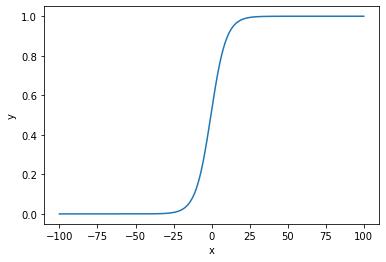

In [14]:
sig = nn.Sigmoid()

yhat = sig(w * x + b)

plt.plot(x, yhat)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## nn.Sequential 을 이용한 Logistic Regression sequential model 정의

In [15]:
model_seq = nn.Sequential(
            nn.Linear(1, 1), 
            nn.Sigmoid())

In [16]:
print(model_seq)
print(list(model_seq.parameters()))

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)
[Parameter containing:
tensor([[0.2294]], requires_grad=True), Parameter containing:
tensor([-0.2380], requires_grad=True)]


In [17]:
model_seq.state_dict()

OrderedDict([('0.weight', tensor([[0.2294]])), ('0.bias', tensor([-0.2380]))])

- 무작위로 초기화된 weight와 bias 를 manually initialize 

In [18]:
model_seq.state_dict()['0.weight'][0] = w
model_seq.state_dict()['0.bias'][0] =b
model_seq.state_dict()

OrderedDict([('0.weight', tensor([[0.2000]])), ('0.bias', tensor([0.1000]))])

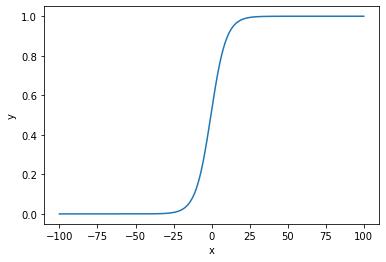

In [19]:
yhat = model_seq(x)

plt.plot(x, yhat.detach())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ``nn.Module``을 이용한 사용자 정의 Logistic Regression model 정의 

In [9]:
class LogisticReg(nn.Module):
    def __init__(self, in_dim):
        super(LogisticReg, self).__init__()
        self.linear = nn.Linear(in_dim, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [10]:
model_custom = LogisticReg(x.shape[1])

# random 하게 초기화 된 parameter 출력
print(model_custom)
print(list(model_custom.parameters()))

LogisticReg(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[0.2742]], requires_grad=True), Parameter containing:
tensor([-0.0511], requires_grad=True)]


- 무작위로 초기화된 weight와 bias 를 manually initialize 

In [11]:
model_custom.state_dict()['linear.weight'][0] = w
model_custom.state_dict()['linear.bias'][0] = b
model_custom.state_dict()

OrderedDict([('linear.weight', tensor([[0.2000]])),
             ('linear.bias', tensor([0.1000]))])

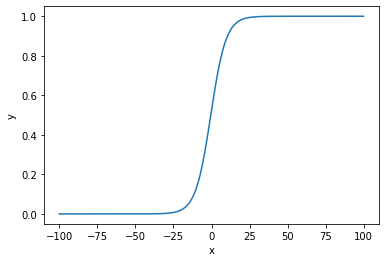

In [12]:
yhat = model_custom(x)

plt.plot(x, yhat.detach())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 생성한 Neural Network Model Train

## Data Class 생성 및 DataLoader를 이용한 Data 구조화

- ``torch.utils.data.DataLoader``는 batch 관리를 담당하는 module 
- 모든 ``torch.utils.data.Dataset``으로 부터 DataLoader 를 생성할 수 있다.  
- DataLoader 는 mini-batch를 iterable(반복자) 형태로 반환

In [13]:
class Data(Dataset):
    def __init__(self):
        self.x = torch.arange(-100, 100, 0.1).view(-1, 1)
        
        # label data 생성 : all zeros
        self.y = torch.zeros(self.x.shape[0], 1)  
        # label 의 절반은 1 을 assign
        half = int(self.y.shape[0]/2)
        self.y[half:, 0] = 1   
        
        self.len = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len

In [14]:
ds = Data()
print(len(ds))
print(ds[:3][0])    # input
print(ds[:3][1])    # target

2000
tensor([[-100.0000],
        [ -99.9000],
        [ -99.8000]])
tensor([[0.],
        [0.],
        [0.]])


### DataLoader 생성

In [15]:
train_dataloader = DataLoader(dataset=ds, batch_size=30, shuffle=True)

### model 생성

In [16]:
model = LogisticReg(1)
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.4272]])),
             ('linear.bias', tensor([0.2381]))])

### Loss Function 및 Optimizer 정의

In [17]:
# def criterion(yhat, y):
#     out = -1 * torch.mean(y * torch.log(yhat) + (1-y) * torch.log(1-yhat))
#     return out

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Train Loop

In [18]:
for epoch in range(100):
    for x, y in train_dataloader:
        yhat = model(x)
        loss = criterion(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()     

### train 된 model 을 이용한 prediction

In [19]:
X = ds[:][0]   # input
Y = ds[:][1]   # target

y_pred = model(X) > 0.5

In [20]:
sum(Y == y_pred) / len(ds)

tensor([0.9995])